# **Train on EMNIST (for letters) and Transfer for MNIST**
* **Basic concepts learnt from: A Deep understanding of Deep Learning (with Python intro) - Mark X Cohen (Udemy) - https://www.udemy.com/course/deeplearning_x**
* **Extended learning and understanding by VigyannVeshi**
* **EMINST Dataset**
    * Dataset containing (A-Z, a-z, 0-9) handwritten character letterimages of size (28,28) grayscale
    * Total 814255 characters

* **MNIST:**
    * MNIST - Modified National Institute of Standards and Technology
    * Image Size: 28x28 pixels
    * Total letterimages: 70,000 (60,000 training, 10,000 testing)
    * Channels: Grayscale, 1 channel

In [1]:
# basic deep learning libraries
import numpy as np
import torch as tr
import torch.nn as nn
import torch.nn.functional as F
import torchvision as tv

# import dataset/loader libraries
from torch.utils.data import TensorDataset,DataLoader
from sklearn.model_selection import train_test_split

# import summary libraries for model information
from torchsummary import summary

# import plotting libraries
import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# extra imports
import copy

_________________________
**Accessing Dataset**

In [2]:
cd ..

/home/rudraksha14/Desktop/RAY_RISE_ABOVE_YOURSELF/Programming/advanced_deep_learning


In [3]:
cd datasets

/home/rudraksha14/Desktop/RAY_RISE_ABOVE_YOURSELF/Programming/advanced_deep_learning/datasets


______________

In [4]:
# Import and inspect the data
letterdata=tv.datasets.EMNIST(root='emnist',split='letters',download=True)
numberdata=tv.datasets.EMNIST(root='emnist',split='digits',download=True)

In [5]:
#inspect the data

# the categories (but how many letters?)

print(letterdata.classes)
print(str(len(letterdata.classes))+'classes')

print("\nData Size:")
print(letterdata.data.shape)

# transform to 4D tensor for conv layers (and transform from int8 to float)
letterimages=letterdata.data.view([124800,1,28,28]).float()
print('\nTensor Data: ')
print(letterimages.shape)


['N/A', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
27classes

Data Size:
torch.Size([124800, 28, 28])

Tensor Data: 
torch.Size([124800, 1, 28, 28])


In [6]:
# so therefore we'll eliminate 'N/A' and subtract 1 from the original labels

# remove the first class category
letterCategories = letterdata.classes[1:]

# relabel labels to start at 0
labels=copy.deepcopy(letterdata.targets)-1
print(labels.shape)

print(tr.sum(labels==0))
print(tr.unique(labels))


torch.Size([124800])
tensor(4800)
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25])


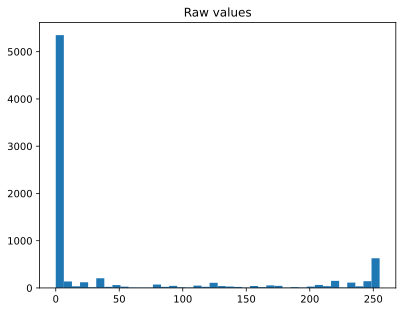

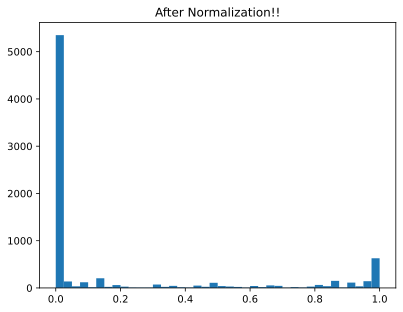

In [7]:
# next issue: do we need to normalize the letterimages?
plt.hist(letterimages[:10,:,:,:].view(1,-1).detach(),40)
plt.title('Raw values')
plt.show()

# yarp.{Means YES!}
letterimages/=tr.max(letterimages)
plt.hist(letterimages[:10,:,:,:].view(1,-1).detach(),40)
plt.title('After Normalization!!')
plt.show()

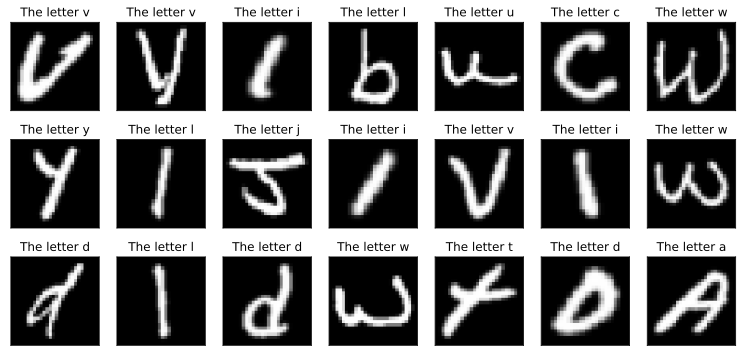

In [8]:
# visualization of some letterimages
fig,axs=plt.subplots(3,7,figsize=(13,6))

for i,ax in enumerate(axs.flatten()):

  # pick a random pic
  whichpic=np.random.randint(letterimages.shape[0])

  # extract the image and its target letter
  I=np.squeeze(letterimages[whichpic,:,:])
  letter=letterCategories[labels[whichpic]]

  # visualize
  ax.imshow(I.T,cmap='gray')
  ax.set_title(f'The letter {letter}')
  ax.set_xticks([])
  ax.set_yticks([])

plt.show()


In [11]:
# Create train/test groups using Dataloader

# step 2: use scikit-learn to split the data
train_data,test_data,train_labels,test_labels=train_test_split(letterimages,labels,test_size=0.1)

# step 3: convert to Pytorch Datasets
train_data=TensorDataset(train_data,train_labels)
test_data= TensorDataset(test_data,test_labels)

# step 4: translate into dataloader objects
batchsize=32
letter_train_loader=DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
letter_test_loader=DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [12]:
# check size (should be letterimages x channels x width x height)
print(letter_train_loader.dataset.tensors[0].shape)
print(letter_train_loader.dataset.tensors[1].shape)

torch.Size([112320, 1, 28, 28])
torch.Size([112320])


In [13]:
### transformations on numbers data

# transform to 4D tensor for conv layers (and transform from int8 to float)
numberImages = numberdata.data.view([numberdata.data.shape[0],1,28,28]).float()
numberImages /= tr.max(numberImages)


# split the images and convert to dataloaders
train_data,test_data, train_labels,test_labels = train_test_split(numberImages, numberdata.targets, test_size=.1)

# convert into PyTorch Datasets
train_data = tr.utils.data.TensorDataset(train_data,train_labels)
test_data  = tr.utils.data.TensorDataset(test_data,test_labels)

# translate into dataloader objects
batchsize = 32
number_train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
number_test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

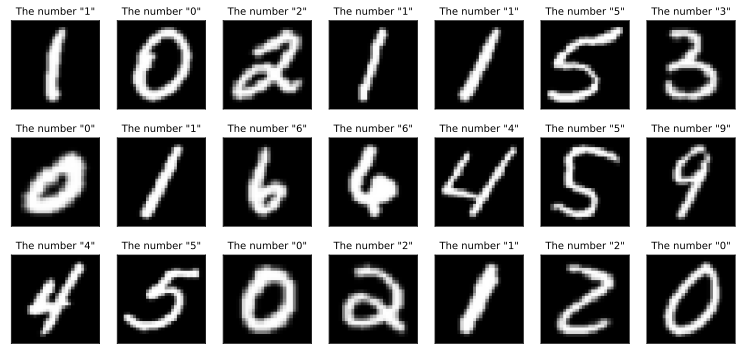

In [15]:
# visualize some numbers
fig,axs = plt.subplots(3,7,figsize=(13,6))

# get a batch of number data
X,y = next(iter(number_train_loader))

for i,ax in enumerate(axs.flatten()):
  
  # extract the image and its target letter
  I = np.squeeze( X[i,:,:] )
  number = y[i].item()
  
  # visualize
  ax.imshow(I.T,cmap='gray',vmin=0,vmax=1)
  ax.set_title('The number "%s"'%number,fontsize=10)
  ax.set_xticks([])
  ax.set_yticks([])

plt.show()

In [16]:
# creating a class for the model
def createNet(printtoggle=False):
    class emnistNet(nn.Module):
        def __init__(self,printtoggle):
            super().__init__()

            ### convolution layers

            # first convolution layer
            self.conv1=nn.Conv2d(1,6,kernel_size=3,stride=1,padding=1)
            self.bnorm1=nn.BatchNorm2d(6) # input the number of channels in this layers
            ### output size: (28+2*1-3)/1 + 1 = 28 --> //2 = 14 (After maxpool (2x2))

            # second convolutional layer
            self.conv2=nn.Conv2d(6,6,kernel_size=3,stride=1,padding=1)
            self.bnorm2=nn.BatchNorm2d(6) # input the number of channels in this layers
            ### output size: (14+2*1-3)/1 + 1 = 14 --> //2 = 7 (After maxpool (2x2))


            ### linear decision layer

            # fully-connected layer
            self.fc1=nn.Linear(7*7*6,50)

            # output layer
            self.out=nn.Linear(50,26)

            # toggle for printing out tensor sizes during forward prop
            self.print=printtoggle

        # forward propogation
        def forward(self,x):
            print(f'Input: {x.shape}') if self.print else None

            ### convolution -> maxpool -> relu (1)
            x = F.leaky_relu(self.bnorm1(F.max_pool2d(self.conv1(x),2)))
            print(f'Layer conv1/pool1: {x.shape}') if self.print else None

            ### convolution -> maxpool -> relu (2)
            x = F.leaky_relu(self.bnorm2(F.max_pool2d(self.conv2(x),2)))
            print(f'Layer conv2/pool2: {x.shape}') if self.print else None

            # reshape for linear layer
            ### x.shape.numel() -->  gives total number of elements in the array/tuple
            nUnits=x.shape.numel()/x.shape[0]
            ### vectorizing
            x=x.view(-1,int(nUnits))
            print(f'Vectorize: {x.shape}') if self.print else None

            # linear layers
            x=F.leaky_relu(self.fc1(x))
            print(f'Layer fc1: {x.shape}') if self.print else None
            x=self.out(x)
            print(f'Layer fc1: {x.shape}') if self.print else None

            return x

    # create the model instance
    net=emnistNet(printtoggle)

    # loss function
    lossfun=nn.CrossEntropyLoss()

    # optimizer
    optimizer=tr.optim.Adam(net.parameters(),lr=0.001)

    return net,lossfun,optimizer

In [17]:
# setting up gpu
# use GPU if available
device = tr.device('cuda:0' if tr.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [18]:
# Create a function that trains the model

def trainModel(net,lossfun,optimizer,train_loader,test_loader,n_epochs=5):


    # send the model to the GPU
    net.to(device)

    # initialize losses
    trainLoss = tr.zeros(n_epochs)
    testLoss = tr.zeros(n_epochs)
    trainErr = tr.zeros(n_epochs)
    testErr = tr.zeros(n_epochs)

    # loop over epochs
    for epochi in range(n_epochs):

        # loop over training data batches
        batchLoss=[]
        batchErr=[]

        for X,y in train_loader:

            # push data to GPU
            X = X.to(device)
            y = y.to(device)

            # forward pass and loss
            yHat=net(X)
            loss=lossfun(yHat,y)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # loss from this batch
            batchLoss.append(loss.item())
            batchErr.append(tr.mean((tr.argmax(yHat,axis=1)!=y).float()).item())

            # end of batch loop ...

        # and get the average losses across the batches
        trainLoss[epochi]=np.mean(batchLoss)
        trainErr[epochi]=100*np.mean(batchErr)

        # test accuracy
        X,y=next(iter(test_loader))
        # push data to GPU
        X = X.to(device)
        y = y.to(device)
        with tr.no_grad(): # deactivates autograd
            yHat=net(X)
            loss=lossfun(yHat,y)

        # compare the following really long lines of code to the training accuracy lines
        testLoss[epochi]=loss.item()
        testErr[epochi]=100*tr.mean((tr.argmax(yHat,axis=1)!=y).float()).item()

        print(f"{epochi+1}/{n_epochs} complete!")
    # end of epochs

    # function output
    return trainLoss,testLoss,trainErr,testErr,net

In [21]:
# Train the model on letters dataset
letternet,lossfun,optimizer=createNet()
trainLoss,testLoss,trainErr,testErr,letternet=trainModel(letternet,lossfun,optimizer,letter_train_loader,letter_test_loader,5)

1/5 complete!
2/5 complete!
3/5 complete!
4/5 complete!
5/5 complete!


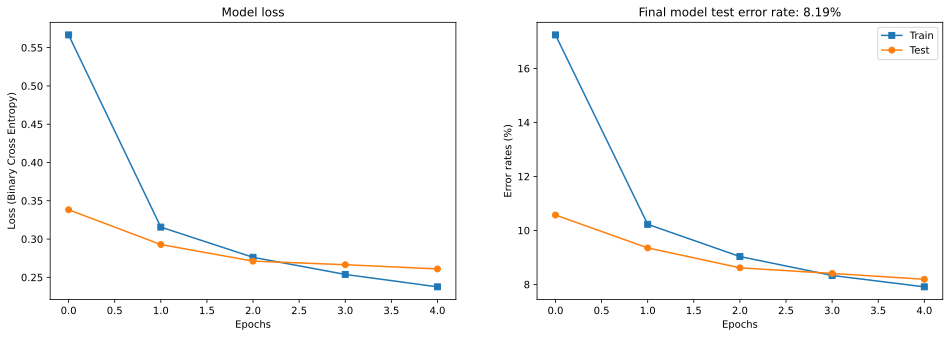

In [22]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainLoss,'s-',label='Train')
ax[0].plot(testLoss,'o-',label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (Binary Cross Entropy)')
ax[0].set_title('Model loss')

ax[1].plot(trainErr,'s-',label='Train')
ax[1].plot(testErr,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Error rates (%)')
ax[1].set_title(f'Final model test error rate: {testErr[-1]:.2f}%')
ax[1].legend()

plt.show()

**1) Using the letternet, test the accuracy of prediction on numberdata**

In [24]:
# extract X,y from NUMBER test dataloader
X,y = next(iter(number_test_loader))
X = X.to(device)
y = y.to(device)

yHat = letternet(X)

# the test
numberAcc = 100*tr.mean((tr.argmax(yHat,axis=1)!=y).float())

print(f'letterNet error rate on NUMBER data: {numberAcc:.2f}%')

letterNet error rate on NUMBER data: 96.78%


**2) Using the letternet - fine tune entire model to 1 epoch and test the accuracy of prediction on numberdata**

In [29]:
# create the target model
numbernet,lossfun,optimizer = createNet()

# then replace all the weights in TARGET model from SOURCE model
for target,source in zip(numbernet.named_parameters(),letternet.named_parameters()):
  target[1].data = copy.deepcopy( source[1].data )

In [30]:
# check out the network
print(numbernet)
print(' ')

# and the final layer
print(numbernet.out)

# replace the final layer to have 10 outputs instead of 26
numbernet.out = nn.Linear(50,10)

# and check it again
print(' ')
print(numbernet)

emnistNet(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bnorm1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(6, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bnorm2): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=294, out_features=50, bias=True)
  (out): Linear(in_features=50, out_features=26, bias=True)
)
 
Linear(in_features=50, out_features=26, bias=True)
 
emnistNet(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bnorm1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(6, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bnorm2): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=294, out_features=50, bias=True)
  (out): Linear(in_features=50, out_features=10, bias=True)
)


In [32]:
# Train the model on letters dataset
trainLoss,testLoss,trainErr,testErr,numbernet=trainModel(numbernet,lossfun,optimizer,number_train_loader,number_test_loader,1)

1/1 complete!


In [33]:
print(f'numberNet TRAIN error rate: {trainErr[-1]:.2f}%')
print(f'numberNet TEST error rate: {testErr[-1]:.2f}%')

numberNet TRAIN error rate: 2.43%
numberNet TEST error rate: 1.08%


**3) Using the letternet - fine tune only fully connected layers to 1 epoch and test the accuracy of prediction on numberdata**

In [34]:
# create the target model
numbernet2,lossfun,optimizer = createNet()

# then replace all the weights in TARGET model from SOURCE model
for target,source in zip(numbernet2.named_parameters(),letternet.named_parameters()):
  target[1].data = copy.deepcopy( source[1].data )

# adjust number of output units
numbernet2.fc2 = nn.Linear(50,10)

# freeze convolution and batch-norm layers
for p in numbernet2.named_parameters():
  if ('conv' in p[0]) or ('bnorm' in p[0]):
    p[1].requires_grad = False

In [35]:
# Train the model on letters dataset
trainLoss,testLoss,trainErr,testErr,numbernet2=trainModel(numbernet2,lossfun,optimizer,number_train_loader,number_test_loader,1)

print(f'numberNet TRAIN error rate: {trainErr[-1]:.2f}%')
print(f'numberNet TEST error rate: {testErr[-1]:.2f}%')

1/1 complete!
numberNet TRAIN error rate: 2.73%
numberNet TEST error rate: 1.27%
